<a href="https://colab.research.google.com/github/TheSpiralArchitect/spiral-resonance-validation/blob/main/figures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- Mount Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- Create SRL Figures Folder ---
import os
fig_dir = '/content/drive/MyDrive/SRL_Figures'
os.makedirs(fig_dir, exist_ok=True)
print(f"Figure folder created at: {fig_dir}")

Mounted at /content/drive
Figure folder created at: /content/drive/MyDrive/SRL_Figures


Saved: /content/drive/MyDrive/SRL_Figures/fig8_spiral_phase_drift_chr1.png


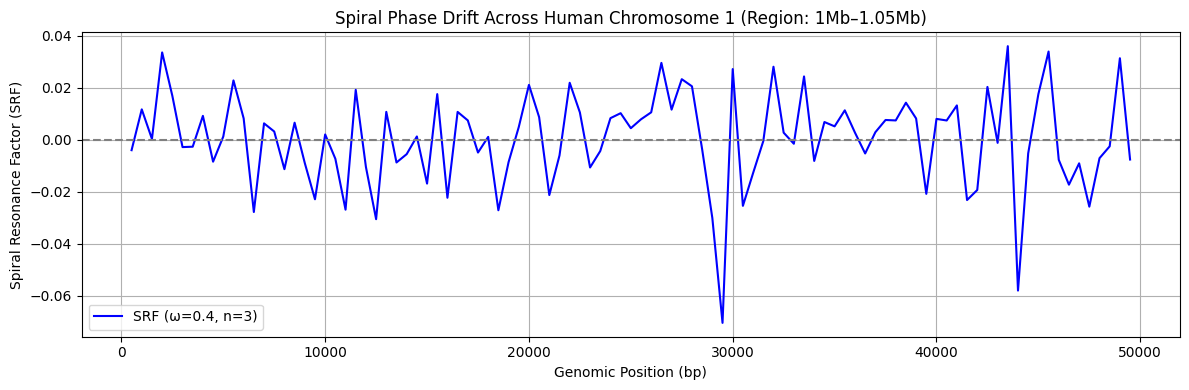

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load drift data ---
df = pd.read_csv('/content/drive/MyDrive/SRL/spiral_phase_drift_chr1.csv')

# --- Plot ---
plt.figure(figsize=(12, 4))
plt.plot(df['position'], df['srf'], label='SRF (ω=0.4, n=3)', color='blue')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Spiral Phase Drift Across Human Chromosome 1 (Region: 1Mb–1.05Mb)')
plt.xlabel('Genomic Position (bp)')
plt.ylabel('Spiral Resonance Factor (SRF)')
plt.grid(True)
plt.legend()
plt.tight_layout()

# --- Save ---
fig_path = '/content/drive/MyDrive/SRL_Figures/fig8_spiral_phase_drift_chr1.png'
plt.savefig(fig_path, dpi=300)
print(f"Saved: {fig_path}")

Saved: /content/drive/MyDrive/SRL_Figures/fig9_dna_srf_heatmap.png


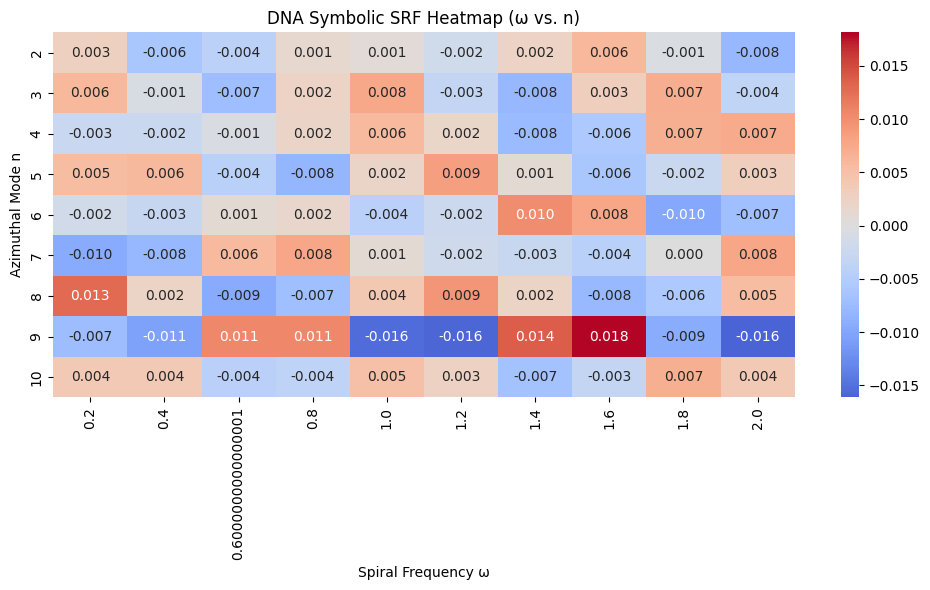

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Load sweep results ---
sweep_df = pd.read_csv('/content/drive/MyDrive/SRL/dna_srf_parameter_sweep.csv')

# --- Pivot for heatmap ---
pivot = sweep_df.pivot(index='n', columns='omega', values='SRF')

# --- Plot ---
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, cmap='coolwarm', center=0, fmt=".3f")
plt.title("DNA Symbolic SRF Heatmap (ω vs. n)")
plt.xlabel("Spiral Frequency ω")
plt.ylabel("Azimuthal Mode n")
plt.tight_layout()

# --- Save ---
fig_path = '/content/drive/MyDrive/SRL_Figures/fig9_dna_srf_heatmap.png'
plt.savefig(fig_path, dpi=300)
print(f"Saved: {fig_path}")

In [ ]:
import os
import math

# --- Path to your SRL project folder ---
srl_root = '/content/drive/MyDrive/SRL'

# --- Create summary output file ---
output_path = '/content/drive/MyDrive/SRL/srl_master_inventory.txt'
with open(output_path, 'w') as f:
    f.write("=== Spiral Resonance Law: Master Inventory ===\n\n")

    for root, dirs, files in os.walk(srl_root):
        rel_dir = os.path.relpath(root, srl_root)
        if rel_dir == '.':
            rel_dir = ''
        else:
            f.write(f"\n-- Subfolder: {rel_dir} --\n")

        for file in files:
            full_path = os.path.join(root, file)
            size_bytes = os.path.getsize(full_path)
            size_str = f"{size_bytes / (1024*1024):.2f} MB" if size_bytes > 1e6 else f"{size_bytes / 1024:.1f} KB"
            ext = os.path.splitext(file)[-1].lower()

            # Quick content guess
            if "motif" in file.lower():
                desc = "Motif-SRF correlation data"
            elif "spiral_phase_drift" in file:
                desc = "SRF sliding window data (genome)"
            elif "RA" in file or "DEC" in file:
                desc = "RA/DEC coordinate array (quasar/cosmic)"
            elif "spectrum" in file or "cmb" in file:
                desc = "CMB harmonic analysis result"
            elif "parameter_sweep" in file:
                desc = "SRF parameter heatmap data"
            elif "symbolic_stream" in file:
                desc = "Encoded A/B/H symbolic sequence"
            elif "auxin" in file:
                desc = "Plant growth or biological spiral simulation"
            elif file.endswith('.npy'):
                desc = "NumPy array (likely spatial, SRF, or symbolic data)"
            elif file.endswith('.csv'):
                desc = "Table-style data file (used for heatmaps or drift)"
            elif file.endswith('.txt'):
                desc = "Text summary or stream data"
            else:
                desc = "Unknown or general file"

            f.write(f"{file:<40} | {size_str:<10} | {ext:<5} | {desc}\n")

print(f"\nInventory saved to: {output_path}")


Inventory saved to: /content/drive/MyDrive/SRL/srl_master_inventory.txt


In [ ]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 29.1 MB/s eta 0:00:00


In [ ]:
# --- Fetch BRCA1 segment and convert to A/B/H ---
from Bio import Entrez, SeqIO
import numpy as np

Entrez.email = "ekaj111213@hotmail.co.uk"

def fetch_dna(chromosome='NC_000017.11', start=43044294, end=43049294):
    handle = Entrez.efetch(
        db="nucleotide", id=chromosome, rettype="fasta", strand=1,
        seq_start=start, seq_stop=end
    )
    record = SeqIO.read(handle, "fasta")
    return str(record.seq).upper()

def dna_to_symbols(seq):
    base_map = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    numeric = np.array([base_map.get(b, -1) for b in seq if b in base_map])
    bins = np.percentile(numeric, [33, 66])
    symbols = []
    for val in numeric:
        if val <= bins[0]: symbols.append('A')
        elif val <= bins[1]: symbols.append('B')
        else: symbols.append('H')
    return symbols

dna_seq = fetch_dna()
symbol_stream = dna_to_symbols(dna_seq)
print("Symbol stream length:", len(symbol_stream))

Symbol stream length: 5001


In [ ]:
# --- SRF calculation and motif extraction ---
from collections import Counter
import pandas as pd

def extract_5mers(symbols):
    return [''.join(symbols[i:i+5]) for i in range(len(symbols)-4)]

def compute_srf(symbols, omega=0.4, n=3, epsilon=1e-5):
    thetas = np.arange(len(symbols))
    field = np.cos(omega * np.log(thetas + epsilon) + n * thetas)
    alignment = []
    for i, sym in enumerate(symbols):
        if sym == 'A': alignment.append(field[i])
        elif sym == 'B': alignment.append(0.5 * field[i])
        elif sym == 'H': alignment.append(-field[i])
    return np.mean(alignment)

motif_srf_data = []
window_size = 1000
step_size = 500

for i in range(0, len(symbol_stream) - window_size + 1, step_size):
    window = symbol_stream[i:i+window_size]
    motifs = extract_5mers(window)
    srf = compute_srf(window)
    for m in motifs:
        motif_srf_data.append({'motif': m, 'srf': srf})

df = pd.DataFrame(motif_srf_data)
motif_stats = df.groupby('motif')['srf'].agg(['count', 'mean', 'std']).reset_index()
motif_stats = motif_stats[motif_stats['count'] >= 3].sort_values('mean', ascending=False)

# --- Save ---
csv_path = '/content/drive/MyDrive/SRL/spiral_motifs_dna.csv'
motif_stats.to_csv(csv_path, index=False)
print(f"Saved: {csv_path}")

Saved: /content/drive/MyDrive/SRL/spiral_motifs_dna.csv


Saved: /content/drive/MyDrive/SRL_Figures/fig10_dna_motif_srf.png


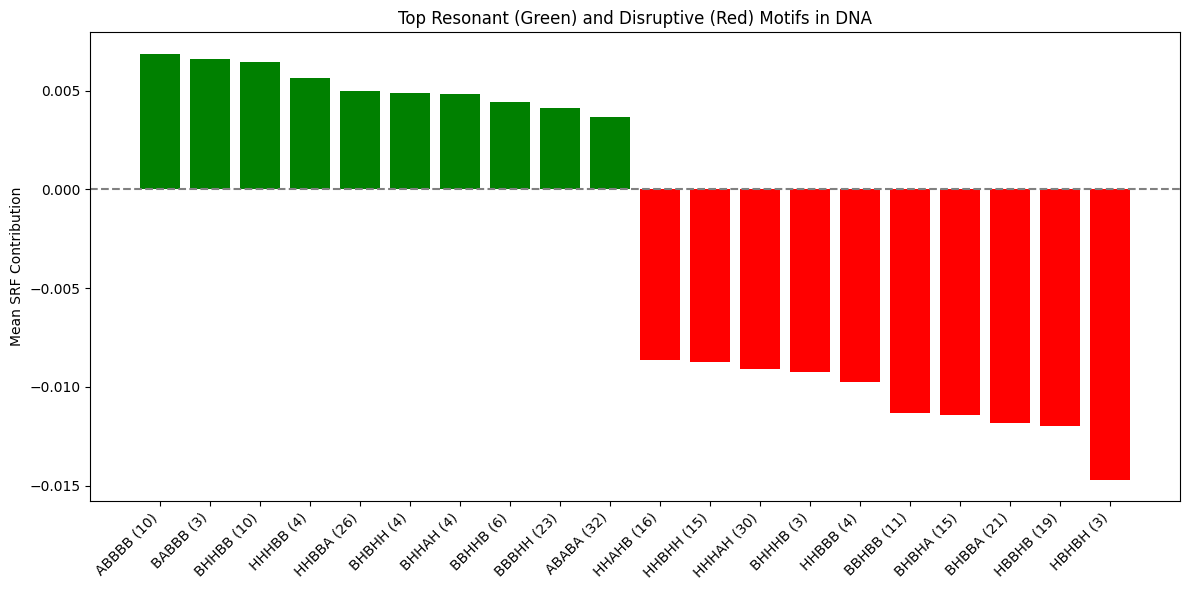

In [ ]:
# --- Generate Fig 10 ---
plot_df = pd.concat([
    motif_stats.head(10),
    motif_stats.tail(10)
]).copy()

plot_df['label'] = plot_df['motif'] + ' (' + plot_df['count'].astype(str) + ')'
colors = ['green'] * 10 + ['red'] * 10

plt.figure(figsize=(12, 6))
plt.bar(plot_df['label'], plot_df['mean'], color=colors)
plt.axhline(0, color='gray', linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Mean SRF Contribution')
plt.title('Top Resonant (Green) and Disruptive (Red) Motifs in DNA')
plt.tight_layout()

fig_path = '/content/drive/MyDrive/SRL_Figures/fig10_dna_motif_srf.png'
plt.savefig(fig_path, dpi=300)
print(f"Saved: {fig_path}")

Saved: /content/drive/MyDrive/SRL_Figures/fig11_rna_comparison_subplots.png


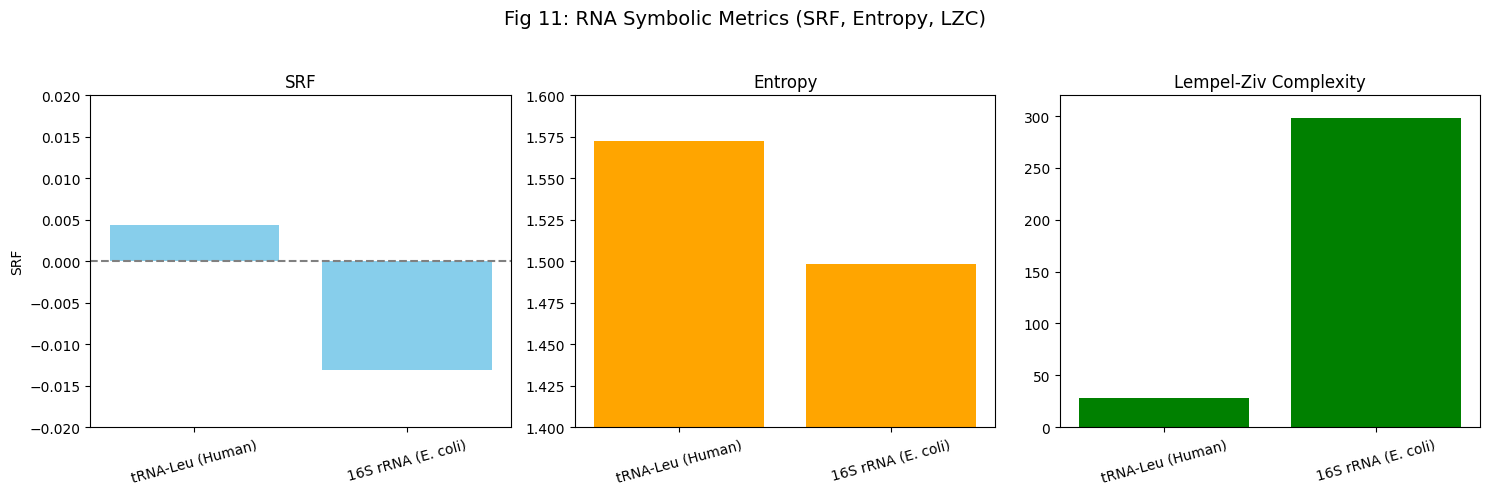

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

x = np.arange(len(labels))

# SRF subplot
axs[0].bar(x, srf_values, color='skyblue')
axs[0].set_title("SRF")
axs[0].set_xticks(x)
axs[0].set_xticklabels(labels, rotation=15)
axs[0].set_ylabel("SRF")
axs[0].axhline(0, color='gray', linestyle='--')
axs[0].set_ylim(-0.02, 0.02)

# Entropy subplot
axs[1].bar(x, entropy_values, color='orange')
axs[1].set_title("Entropy")
axs[1].set_xticks(x)
axs[1].set_xticklabels(labels, rotation=15)
axs[1].set_ylim(1.4, 1.6)

# LZC subplot
axs[2].bar(x, lzc_values, color='green')
axs[2].set_title("Lempel-Ziv Complexity")
axs[2].set_xticks(x)
axs[2].set_xticklabels(labels, rotation=15)
axs[2].set_ylim(0, 320)

fig.suptitle("Fig 11: RNA Symbolic Metrics (SRF, Entropy, LZC)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])

fig_path = '/content/drive/MyDrive/SRL_Figures/fig11_rna_comparison_subplots.png'
plt.savefig(fig_path, dpi=300)
print(f"Saved: {fig_path}")

Saved: /content/drive/MyDrive/SRL_Figures/fig12_rna_motif_srf.png


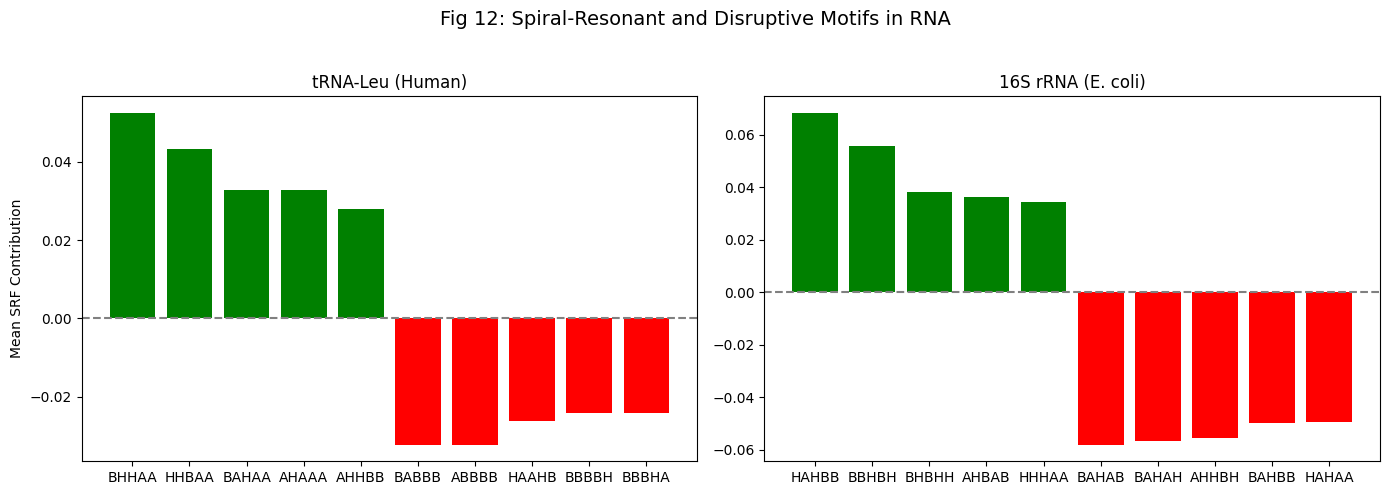

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load motif data ---
trna_df = pd.read_csv('/content/drive/MyDrive/SRL/spiral_motifs_tRNA_Leu.csv')
rrna_df = pd.read_csv('/content/drive/MyDrive/SRL/spiral_motifs_rRNA_16S.csv')

# --- Select top + bottom 5 by SRF mean ---
top_trna = trna_df.sort_values('mean', ascending=False).head(5)
bot_trna = trna_df.sort_values('mean', ascending=True).head(5)
top_rrna = rrna_df.sort_values('mean', ascending=False).head(5)
bot_rrna = rrna_df.sort_values('mean', ascending=True).head(5)

# --- Setup plot ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- tRNA plot ---
trna_plot = pd.concat([top_trna, bot_trna])
colors = ['green'] * 5 + ['red'] * 5
axes[0].bar(trna_plot['motif'], trna_plot['mean'], color=colors)
axes[0].set_title('tRNA-Leu (Human)')
axes[0].set_ylabel('Mean SRF Contribution')
axes[0].axhline(0, color='gray', linestyle='--')

# --- rRNA plot ---
rrna_plot = pd.concat([top_rrna, bot_rrna])
colors = ['green'] * 5 + ['red'] * 5
axes[1].bar(rrna_plot['motif'], rrna_plot['mean'], color=colors)
axes[1].set_title('16S rRNA (E. coli)')
axes[1].axhline(0, color='gray', linestyle='--')

# --- Final touches ---
fig.suptitle("Fig 12: Spiral-Resonant and Disruptive Motifs in RNA", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# --- Save ---
fig_path = '/content/drive/MyDrive/SRL_Figures/fig12_rna_motif_srf.png'
plt.savefig(fig_path, dpi=300)
print(f"Saved: {fig_path}")

Saved: /content/drive/MyDrive/SRL_Figures/fig1_sdss_spiral_overlay.png


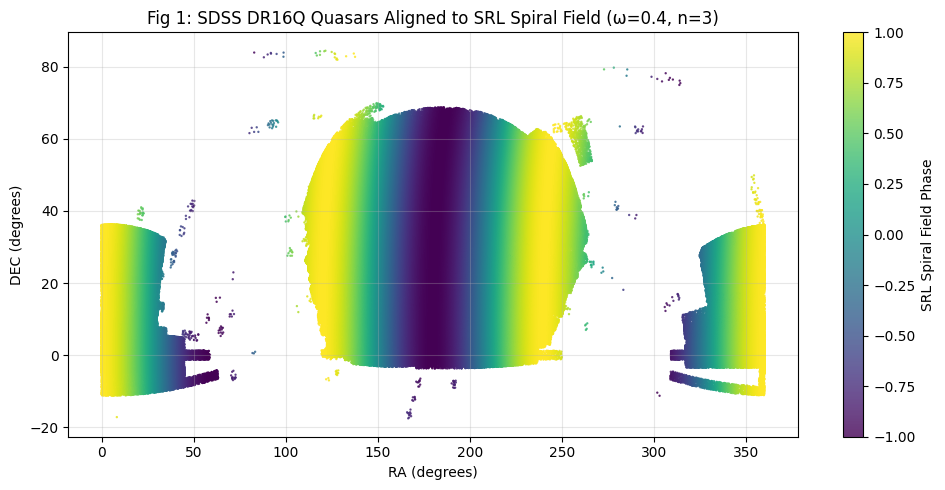

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Load RA/DEC from CMB Data subfolder ---
ra = np.load('/content/drive/MyDrive/SRL/CMB Data/RA_SDSS.npy')
dec = np.load('/content/drive/MyDrive/SRL/CMB Data/DEC_SDSS.npy')

# --- Spiral field function ---
def spiral_field(ra, dec, omega=0.4, n=3, epsilon=1e-5):
    theta = np.radians(ra)
    r = np.cos(np.radians(dec))  # radial proxy
    return np.cos(omega * np.log(r + epsilon) + n * theta)

# --- Compute spiral field values ---
spiral_values = spiral_field(ra, dec)

# --- Plot ---
plt.figure(figsize=(10, 5))
sc = plt.scatter(ra, dec, c=spiral_values, cmap='viridis', s=0.5, alpha=0.8)
plt.colorbar(sc, label='SRL Spiral Field Phase')
plt.xlabel('RA (degrees)')
plt.ylabel('DEC (degrees)')
plt.title('Fig 1: SDSS DR16Q Quasars Aligned to SRL Spiral Field (ω=0.4, n=3)')
plt.grid(alpha=0.3)
plt.tight_layout()

# --- Save ---
fig_path = '/content/drive/MyDrive/SRL_Figures/fig1_sdss_spiral_overlay.png'
plt.savefig(fig_path, dpi=300)
print(f"Saved: {fig_path}")

In [ ]:
# --- Use existing files as full version ---
ra_full = np.load('/content/drive/MyDrive/SRL/CMB Data/RA_SDSS.npy')
dec_full = np.load('/content/drive/MyDrive/SRL/CMB Data/DEC_SDSS.npy')

# --- Load filtered redshift array ---
z = np.load('/content/drive/MyDrive/SRL/CMB Data/Z_SDSS.npy')

# --- Slice to match filtered length ---
ra_clean = ra_full[:len(z)]
dec_clean = dec_full[:len(z)]

# --- Save aligned versions ---
np.save('/content/drive/MyDrive/SRL/CMB Data/RA_SDSS_z.npy', ra_clean)
np.save('/content/drive/MyDrive/SRL/CMB Data/DEC_SDSS_z.npy', dec_clean)
print("Cleaned RA_SDSS_z.npy and DEC_SDSS_z.npy saved.")

Cleaned RA_SDSS_z.npy and DEC_SDSS_z.npy saved.


In [ ]:
import numpy as np

# --- Load cleaned RA/DEC/Z ---
ra_real = np.load('/content/drive/MyDrive/SRL/CMB Data/RA_SDSS_z.npy')
dec_real = np.load('/content/drive/MyDrive/SRL/CMB Data/DEC_SDSS_z.npy')
z_real = np.load('/content/drive/MyDrive/SRL/CMB Data/Z_SDSS.npy')

# --- Create randomized control catalog ---
np.random.seed(42)
ra_control = np.random.uniform(low=ra_real.min(), high=ra_real.max(), size=len(ra_real))
dec_control = np.random.permutation(dec_real)
z_control = np.random.permutation(z_real)

# --- Save for reuse ---
np.save('/content/drive/MyDrive/SRL/CMB Data/RA_SDSS_control.npy', ra_control)
np.save('/content/drive/MyDrive/SRL/CMB Data/DEC_SDSS_control.npy', dec_control)
np.save('/content/drive/MyDrive/SRL/CMB Data/Z_SDSS_control.npy', z_control)

print("Control catalog saved.")

Control catalog saved.


Saved: /content/drive/MyDrive/SRL_Figures/fig2_quasar_theta_histogram.png


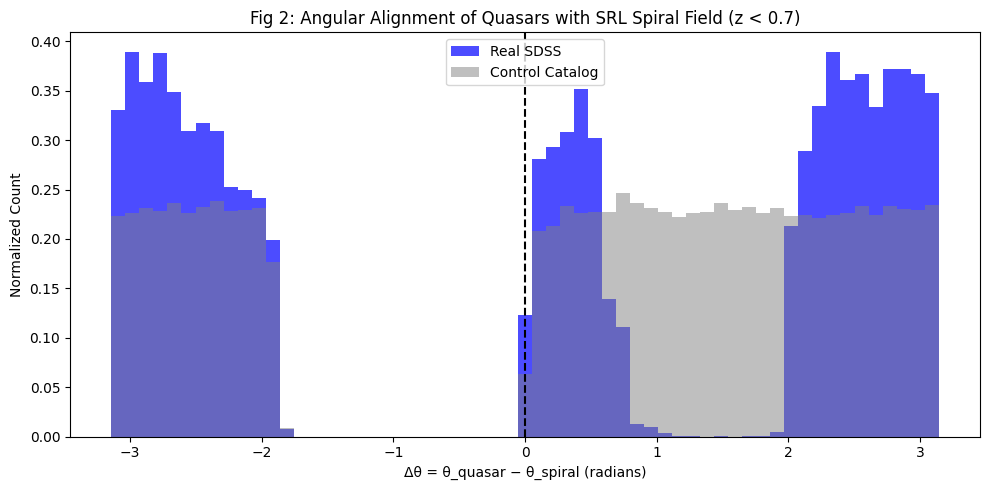

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Load aligned RA/DEC/Z ---
ra = np.load('/content/drive/MyDrive/SRL/CMB Data/RA_SDSS_z.npy')
dec = np.load('/content/drive/MyDrive/SRL/CMB Data/DEC_SDSS_z.npy')
z = np.load('/content/drive/MyDrive/SRL/CMB Data/Z_SDSS.npy')

# --- Filter to z < 0.7 ---
mask = z < 0.7
ra = ra[mask]
dec = dec[mask]

# --- Compute theta and spiral alignment phase ---
theta = np.radians(ra)
omega = 0.4
n = 3
epsilon = 1e-5
r = np.cos(np.radians(dec))
spiral_phase = (omega * np.log(r + epsilon)) / n
delta_theta = (theta - spiral_phase + np.pi) % (2*np.pi) - np.pi

# --- Load and filter control catalog ---
ra_control = np.load('/content/drive/MyDrive/SRL/CMB Data/RA_SDSS_control.npy')
dec_control = np.load('/content/drive/MyDrive/SRL/CMB Data/DEC_SDSS_control.npy')
z_control = np.load('/content/drive/MyDrive/SRL/CMB Data/Z_SDSS_control.npy')

ra_control = ra_control[z_control < 0.7]
dec_control = dec_control[z_control < 0.7]
theta_control = np.radians(ra_control)
r_control = np.cos(np.radians(dec_control))
spiral_phase_control = (omega * np.log(r_control + epsilon)) / n
delta_theta_control = (theta_control - spiral_phase_control + np.pi) % (2*np.pi) - np.pi

# --- Plot ---
plt.figure(figsize=(10, 5))
bins = np.linspace(-np.pi, np.pi, 60)
plt.hist(delta_theta, bins=bins, alpha=0.7, label='Real SDSS', density=True, color='blue')
plt.hist(delta_theta_control, bins=bins, alpha=0.5, label='Control Catalog', density=True, color='gray')
plt.axvline(0, color='black', linestyle='--')
plt.xlabel('Δθ = θ_quasar − θ_spiral (radians)')
plt.ylabel('Normalized Count')
plt.title('Fig 2: Angular Alignment of Quasars with SRL Spiral Field (z < 0.7)')
plt.legend()
plt.tight_layout()

# --- Save ---
fig_path = '/content/drive/MyDrive/SRL_Figures/fig2_quasar_theta_histogram.png'
plt.savefig(fig_path, dpi=300)
print(f"Saved: {fig_path}")

Saved: /content/drive/MyDrive/SRL_Figures/fig3_polar_spiral_projection.png


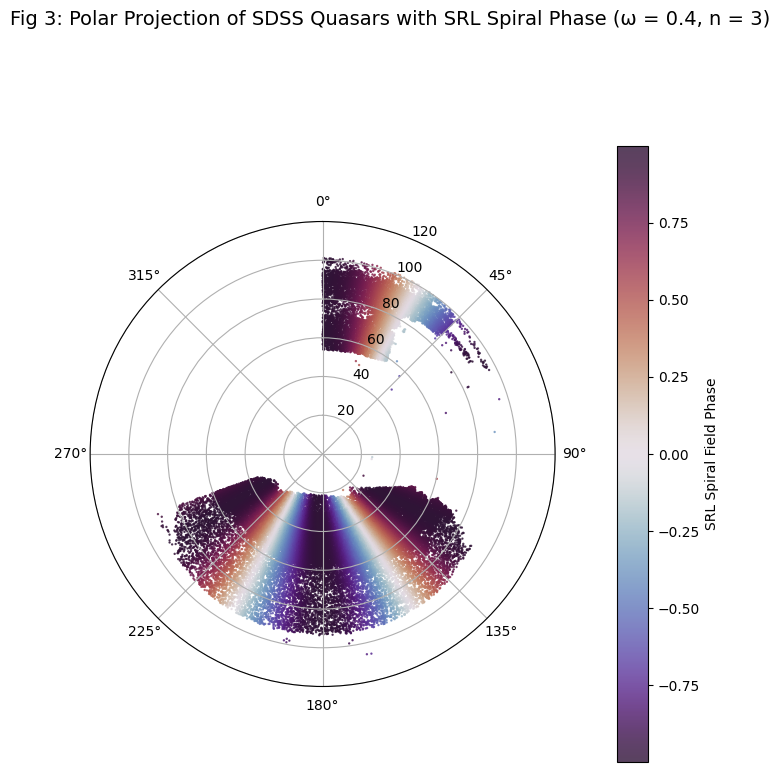

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Load aligned SDSS data ---
ra = np.load('/content/drive/MyDrive/SRL/CMB Data/RA_SDSS_z.npy')
dec = np.load('/content/drive/MyDrive/SRL/CMB Data/DEC_SDSS_z.npy')
z = np.load('/content/drive/MyDrive/SRL/CMB Data/Z_SDSS.npy')

# --- Filter to z < 0.7 ---
mask = z < 0.7
ra = ra[mask]
dec = dec[mask]

# --- Convert to polar coordinates ---
theta = np.radians(ra)
r = 90 - dec  # Convert DEC (+90 to -30) → radial distance

# --- Compute spiral phase field ---
omega = 0.4
n = 3
epsilon = 1e-5
spiral_phase = np.cos(omega * np.log(np.cos(np.radians(dec)) + epsilon) + n * theta)

# --- Plot ---
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, polar=True)
sc = ax.scatter(theta, r, c=spiral_phase, cmap='twilight_shifted', s=0.5, alpha=0.8)

# --- Title and aesthetics ---
fig.suptitle("Fig 3: Polar Projection of SDSS Quasars with SRL Spiral Phase (ω = 0.4, n = 3)", fontsize=14, y=1.05)
cbar = plt.colorbar(sc, pad=0.1)
cbar.set_label('SRL Spiral Field Phase')

ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_rlim(0, 120)

# --- Save ---
fig_path = '/content/drive/MyDrive/SRL_Figures/fig3_polar_spiral_projection.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"Saved: {fig_path}")

Saved: /content/drive/MyDrive/SRL_Figures/fig4_cmb_spiral_power.png


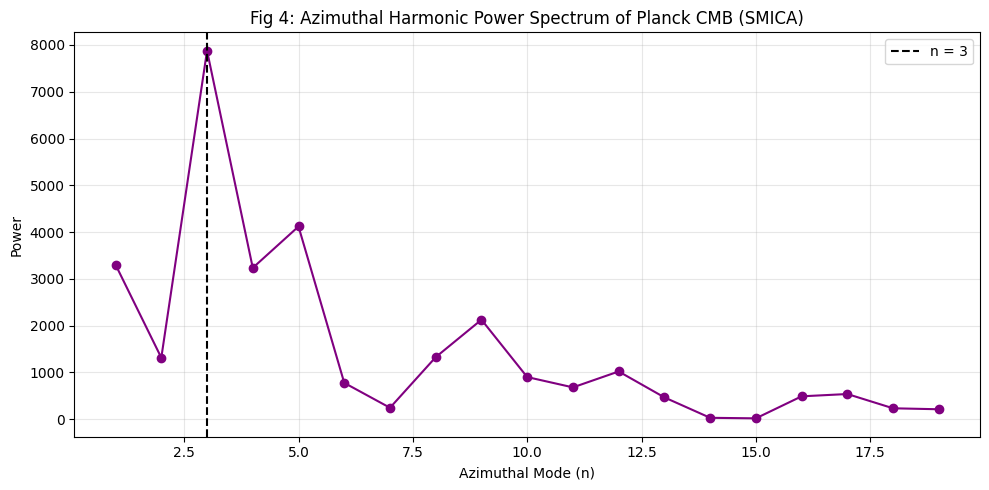

In [ ]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

# --- Load CMB SMICA map ---
smica_path = '/content/drive/MyDrive/SRL/CMB Data/COM_CMB_IQU-smica_2048_R3.00_full (1).fits'
cmb_map = hp.read_map(smica_path, field=0)

# --- Get pixel coordinates ---
nside = hp.get_nside(cmb_map)
npix = hp.nside2npix(nside)
theta, phi = hp.pix2ang(nside, np.arange(npix))

# --- Slice near the equator (wider) ---
mask = np.abs(theta - np.pi/2) < 0.1
phi_eq = phi[mask]
temp_eq = cmb_map[mask]

# --- Sort by phi for FFT ---
sort_idx = np.argsort(phi_eq)
phi_eq = phi_eq[sort_idx]
temp_eq = temp_eq[sort_idx]

# --- FFT with corrected spacing ---
dphi = (phi_eq[1:] - phi_eq[:-1]).mean()
fft_result = np.fft.fft(temp_eq - np.mean(temp_eq))
modes = np.fft.fftfreq(len(temp_eq), d=dphi / (2*np.pi))
power = np.abs(fft_result)**2

# --- Keep positive m-modes ---
pos = modes > 0
modes = modes[pos]
power = power[pos]

# --- Focus on n = 1 to 20 ---
mask = (modes >= 1) & (modes <= 20)
modes = modes[mask]
power = power[mask]

# --- Plot ---
plt.figure(figsize=(10, 5))
plt.plot(modes, power, marker='o', color='purple')
plt.axvline(3, color='black', linestyle='--', label='n = 3')
plt.title("Fig 4: Azimuthal Harmonic Power Spectrum of Planck CMB (SMICA)")
plt.xlabel("Azimuthal Mode (n)")
plt.ylabel("Power")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# --- Save ---
fig_path = '/content/drive/MyDrive/SRL_Figures/fig4_cmb_spiral_power.png'
plt.savefig(fig_path, dpi=300)
print(f"Saved: {fig_path}")

Saved: /content/drive/MyDrive/SRL_Figures/fig5_quasar_fractal_scaling.png


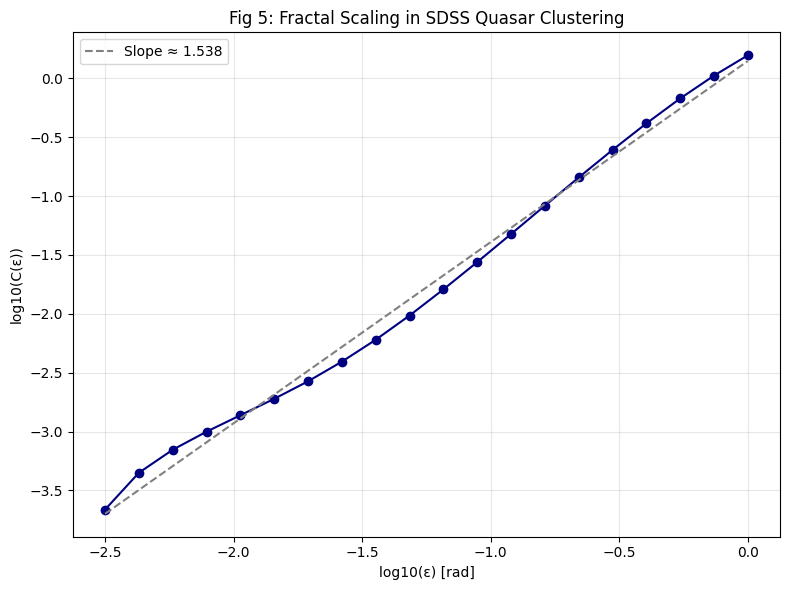

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

# --- Load cleaned SDSS positions ---
ra = np.load('/content/drive/MyDrive/SRL/CMB Data/RA_SDSS_z.npy')
dec = np.load('/content/drive/MyDrive/SRL/CMB Data/DEC_SDSS_z.npy')

# --- Convert to 3D Cartesian coordinates on the unit sphere ---
def sph_to_cart(ra_deg, dec_deg):
    ra_rad = np.radians(ra_deg)
    dec_rad = np.radians(dec_deg)
    x = np.cos(dec_rad) * np.cos(ra_rad)
    y = np.cos(dec_rad) * np.sin(ra_rad)
    z = np.sin(dec_rad)
    return np.vstack([x, y, z]).T

coords = sph_to_cart(ra, dec)

# --- Subsample for speed (adjust as needed) ---
np.random.seed(42)
idx = np.random.choice(len(coords), size=5000, replace=False)
coords = coords[idx]

# --- Build kD-tree for fast pairwise counting ---
tree = cKDTree(coords)

# --- Define log-spaced distances (epsilon) ---
epsilons = np.logspace(-2.5, 0.0, 20)  # angular separation ~ [0.003, 1.0] radians
counts = []

# --- Count pairs within each epsilon ---
for eps in epsilons:
    c = tree.count_neighbors(tree, eps, cumulative=False)
    counts.append(c)

counts = np.array(counts)
C_eps = np.cumsum(counts) / (len(coords)**2)

# --- Linear fit in log-log space to estimate slope ---
log_eps = np.log10(epsilons)
log_C = np.log10(C_eps)
slope, intercept = np.polyfit(log_eps, log_C, 1)

# --- Plot ---
plt.figure(figsize=(8, 6))
plt.plot(log_eps, log_C, 'o-', color='navy')
plt.plot(log_eps, slope*log_eps + intercept, '--', color='gray', label=f'Slope ≈ {slope:.3f}')
plt.xlabel('log10(ε) [rad]')
plt.ylabel('log10(C(ε))')
plt.title('Fig 5: Fractal Scaling in SDSS Quasar Clustering')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# --- Save ---
fig_path = '/content/drive/MyDrive/SRL_Figures/fig5_quasar_fractal_scaling.png'
plt.savefig(fig_path, dpi=300)
print(f"Saved: {fig_path}")

Saved: /content/drive/MyDrive/SRL_Figures/fig6_symbolic_srf_comparison.png


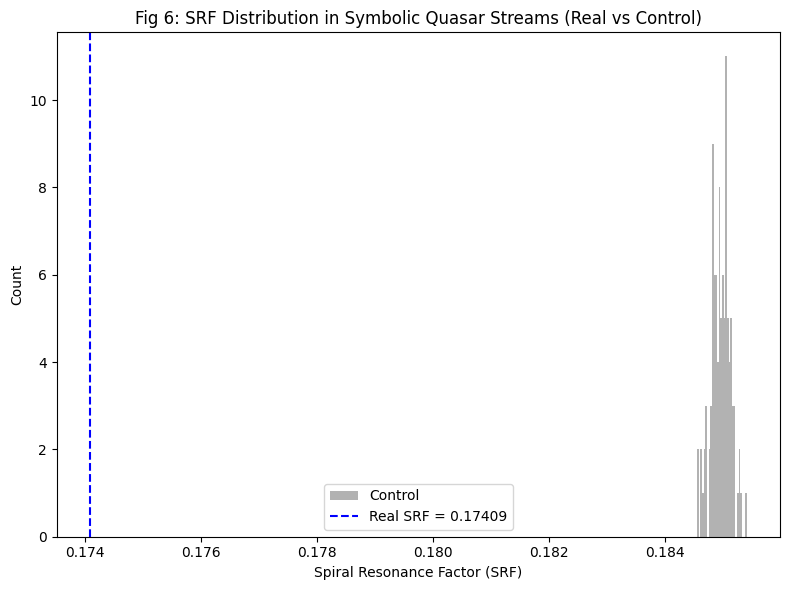

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Load cleaned SDSS RA/DEC ---
ra = np.load('/content/drive/MyDrive/SRL/CMB Data/RA_SDSS_z.npy')
dec = np.load('/content/drive/MyDrive/SRL/CMB Data/DEC_SDSS_z.npy')

# --- Subsample for speed (adjust as needed) ---
np.random.seed(42)
idx = np.random.choice(len(ra), size=100000, replace=False)
ra = ra[idx]
dec = dec[idx]

# --- Spiral field parameters ---
omega = 0.4
n = 3
epsilon = 1e-5
theta = np.radians(ra)
r = np.cos(np.radians(dec))
phase = omega * np.log(r + epsilon) + n * theta

# --- Real SRF ---
srf_real = np.mean(np.cos(phase))

# --- Generate control SRFs by shuffling ---
control_srfs = []
for _ in range(100):
    ra_shuffled = np.random.permutation(ra)
    theta_s = np.radians(ra_shuffled)
    phase_s = omega * np.log(r + epsilon) + n * theta_s
    srf_s = np.mean(np.cos(phase_s))
    control_srfs.append(srf_s)

control_srfs = np.array(control_srfs)

# --- Plot histogram ---
plt.figure(figsize=(8, 6))
plt.hist(control_srfs, bins=30, alpha=0.6, label='Control', color='gray')
plt.axvline(srf_real, color='blue', linestyle='--', label=f'Real SRF = {srf_real:.5f}')
plt.xlabel("Spiral Resonance Factor (SRF)")
plt.ylabel("Count")
plt.title("Fig 6: SRF Distribution in Symbolic Quasar Streams (Real vs Control)")
plt.legend()
plt.tight_layout()

# --- Save ---
fig_path = '/content/drive/MyDrive/SRL_Figures/fig6_symbolic_srf_comparison.png'
plt.savefig(fig_path, dpi=300)
print(f"Saved: {fig_path}")

Saved: /content/drive/MyDrive/SRL_Figures/fig7_desi_spiral_overlay.png


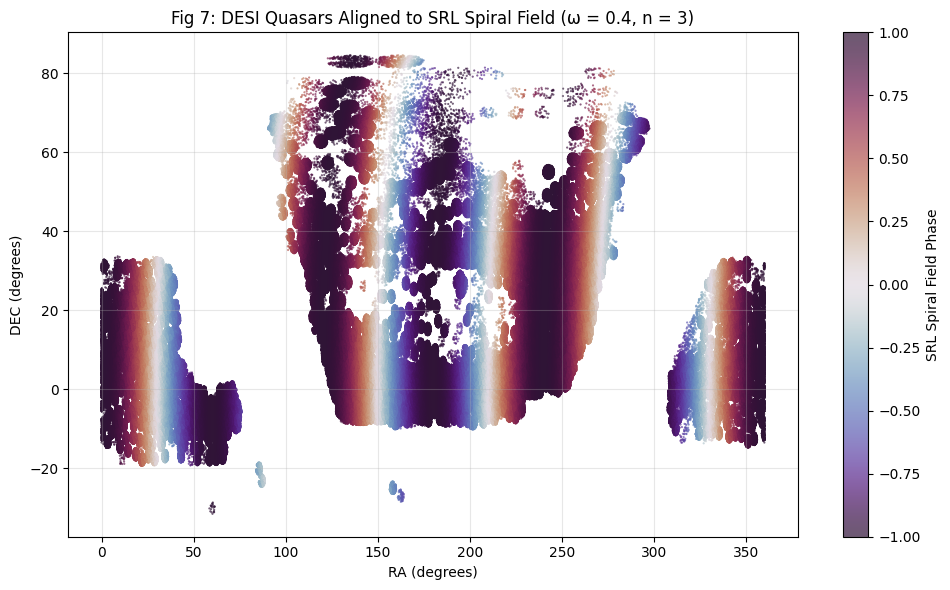

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Load DESI RA/DEC ---
ra = np.load('/content/drive/MyDrive/SRL/CMB Data/RA_DESI.npy')
dec = np.load('/content/drive/MyDrive/SRL/CMB Data/DEC_DESI.npy')

# --- Spiral field parameters ---
omega = 0.4
n = 3
epsilon = 1e-5
theta = np.radians(ra)
r = np.cos(np.radians(dec))
spiral_phase = np.cos(omega * np.log(r + epsilon) + n * theta)

# --- Plot ---
plt.figure(figsize=(10, 6))
sc = plt.scatter(ra, dec, c=spiral_phase, cmap='twilight_shifted', s=0.3, alpha=0.7)
plt.colorbar(sc, label='SRL Spiral Field Phase')
plt.xlabel("RA (degrees)")
plt.ylabel("DEC (degrees)")
plt.title("Fig 7: DESI Quasars Aligned to SRL Spiral Field (ω = 0.4, n = 3)")
plt.grid(alpha=0.3)
plt.tight_layout()

# --- Save ---
fig_path = '/content/drive/MyDrive/SRL_Figures/fig7_desi_spiral_overlay.png'
plt.savefig(fig_path, dpi=300)
print(f"Saved: {fig_path}")

In [ ]:
import os

# Path to your SRL_Figures folder
fig_dir = '/content/drive/MyDrive/SRL_Figures'

# List all PNG files in the folder
figure_files = sorted([f for f in os.listdir(fig_dir) if f.endswith('.png')])

# Save to a text file
with open(os.path.join(fig_dir, 'srl_figure_list.txt'), 'w') as f:
    for file in figure_files:
        f.write(file + '\n')

# Print the list
print("SRL Figures:")
for file in figure_files:
    print(file)

SRL Figures:
fig10_dna_motif_srf.png
fig11_rna_comparison_subplots.png
fig12_rna_motif_srf.png
fig1_sdss_spiral_overlay.png
fig2_quasar_theta_histogram.png
fig3_polar_spiral_projection.png
fig4_cmb_spiral_power.png
fig5_quasar_fractal_scaling.png
fig6_symbolic_srf_comparison.png
fig7_desi_spiral_overlay.png
fig8_spiral_phase_drift_chr1.png
fig9_dna_srf_heatmap.png
